# CARGA INICIAL DE LIBRERIAS

In [6]:
# 🔌 Cargar la extensión de Kedro en Jupyter
%load_ext kedro.ipython
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


# Carga dataset

In [2]:
# =========================================================
# 🔌 Cargar dataset desde el catálogo
# =========================================================
df = catalog.load("Features_clustering_v1").copy()
df.head()

[11/27/25 01:23:54] INFO     Loading data from Features_clustering_v1 (ParquetDataset)...      ]8;id=451028;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=888190;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

,AmountZScoreByLocation,IsAnomaly,IsLateNight,IsWeekend,is_fraud,cluster_id
0,-0.597657,0,1,0,0,4
1,2.193792,0,0,0,0,3
2,0.693326,0,0,1,0,5
3,0.351537,0,0,0,0,0
4,-0.758692,0,0,1,0,1


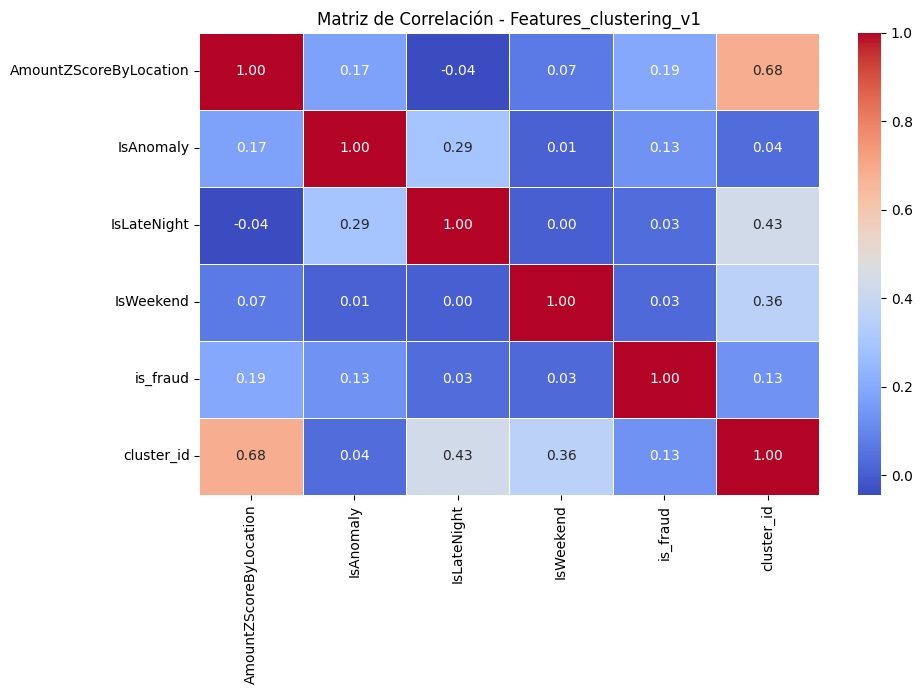

In [4]:
plt.figure(figsize=(10, 6))

corr = df.corr()   # solo numéricas
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Matriz de Correlación - Features_clustering_v1")
plt.show()

La matriz de correlación muestra que la nueva característica `cluster_id` captura información relevante del comportamiento transaccional que no era evidente a partir de las variables originales:

- `cluster_id` presenta una correlación **moderada-alta con AmountZScoreByLocation (0.68)**, lo que indica que K-Means agrupó fuertemente según montos atípicos, un patrón consistente con el análisis previo.
- También presenta correlación **moderada con IsLateNight (0.43)** y **IsWeekend (0.36)**, reflejando que los clusters diferencian patrones temporales de actividad.
- La correlación con `is_fraud` es **0.13**, lo cual es bajo pero **esperable**, ya que el fraude es un evento raro y no lineal. Aun así, es superior a algunas variables individuales (IsLateNight = 0.03, IsWeekend = 0.03), lo que confirma que `cluster_id` aporta capacidad discriminativa adicional.
- Las correlaciones entre variables originales se mantienen bajas, lo que confirma que el conjunto de features tiene **baja colinealidad**, adecuado para modelos supervisados.

En conjunto, esto valida que `cluster_id` es una feature útil y no redundante, y que sintetiza patrones complejos que mejorarán el modelo de clasificación de fraude en la siguiente etapa.

# Entrenamos XGBREGRESSOR CON LA NUEVA VARIABLE

F1 promedio (CV): 0.055939019203737186
Desviación estándar: 0.0019755847734646247
              precision    recall  f1-score   support

           0      1.000     0.687     0.814    194879
           1      0.030     0.970     0.059      1969

    accuracy                          0.690    196848
   macro avg      0.515     0.828     0.437    196848
weighted avg      0.990     0.690     0.807    196848



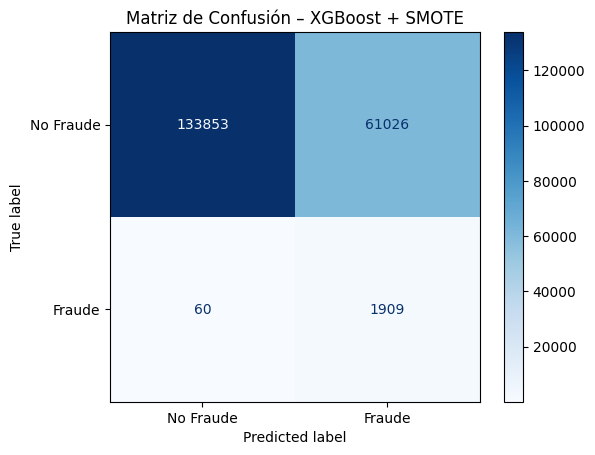

In [5]:
# ============================================================
# 1) Preparar datos (X incluye cluster_id)
# ============================================================
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

# ============================================================
# 2) SMOTE para oversampling de fraude
# ============================================================
smote = SMOTE(random_state=42)

# ============================================================
# 3) Modelo XGBoost
# ============================================================
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=10,    # muy importante en fraude
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

# ============================================================
# 4) Pipeline combinado
# ============================================================
pipe = Pipeline([
    ("smote", smote),
    ("model", xgb)
])

# ============================================================
# 5) Validación Cruzada
# ============================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1")

print("F1 promedio (CV):", scores.mean())
print("Desviación estándar:", scores.std())

# ============================================================
# 6) Entrenar con train/test split
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# ============================================================
# 7) Evaluación Final
# ============================================================
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraude", "Fraude"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión – XGBoost + SMOTE")
plt.show()

# Busqueda de mejores parametros

Ratio clases (neg/pos): 98.99390429747028

Entrenando búsqueda rápida de hiperparámetros...
Fitting 2 folds for each of 3 candidates, totalling 6 fits

✔ BÚSQUEDA EXPRESS COMPLETADA ✔

Mejor F1 (CV): 0.03355612474988848
Mejores parámetros encontrados:
  model__subsample: 0.8
  model__scale_pos_weight: 32.99796809915676
  model__n_estimators: 200
  model__max_depth: 4
  model__learning_rate: 0.1
  model__colsample_bytree: 1.0

📊 CLASSIFICATION REPORT (MEJOR MODELO)
              precision    recall  f1-score   support

           0      1.000     0.459     0.629    194879
           1      0.018     0.984     0.035      1969

    accuracy                          0.464    196848
   macro avg      0.509     0.721     0.332    196848
weighted avg      0.990     0.464     0.623    196848



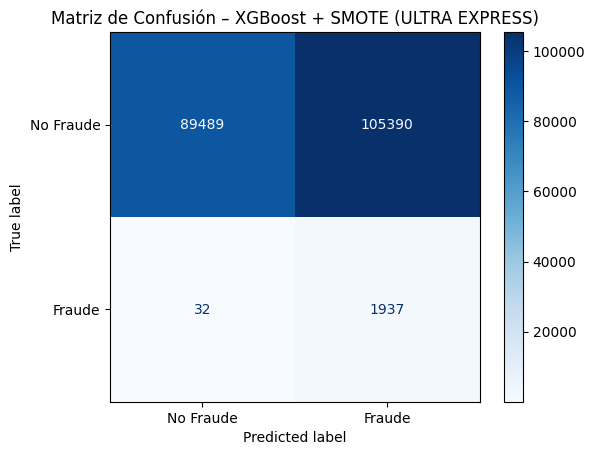

In [9]:

# ============================================================
# 1) Preparar datos (X incluye cluster_id)
# ============================================================
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

# Ratio clases
neg, pos = (y == 0).sum(), (y == 1).sum()
ratio = neg / pos
print("Ratio clases (neg/pos):", ratio)

# ============================================================
# 2) SMOTE + XGBoost
# ============================================================
smote = SMOTE(random_state=42)

xgb = XGBClassifier(
    eval_metric="auc",
    random_state=42,
    n_jobs=-1,
    tree_method="approx"   # 🚀 MÁS RÁPIDO QUE HIST
)

pipe = Pipeline([
    ("smote", smote),
    ("model", xgb)
])

# ============================================================
# 3) HIPERPARÁMETROS (VERSION EXPRESS)
# ============================================================
param_distributions = {
    "model__n_estimators": [200, 300],           # menos combinaciones
    "model__learning_rate": [0.05, 0.1],         # rangos chicos
    "model__max_depth": [3, 4, 5],               # rangos chicos
    "model__subsample": [0.8, 1.0],              # 2 opciones
    "model__colsample_bytree": [0.8, 1.0],       # 2 opciones
    "model__scale_pos_weight": [ratio/3, ratio/4]  # valores realistas
}

# ============================================================
# 4) RandomizedSearch — ULTRA EXPRESS 🚀
# ============================================================
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=3,            # SOLO 3 MODELOS 🤯
    scoring="f1",
    cv=cv,
    verbose=1,           # no tanto spam
    n_jobs=-1,
    random_state=42
)

print("\nEntrenando búsqueda rápida de hiperparámetros...")
random_search.fit(X, y)
print("\n✔ BÚSQUEDA EXPRESS COMPLETADA ✔")

print("\nMejor F1 (CV):", random_search.best_score_)
print("Mejores parámetros encontrados:")
for k, v in random_search.best_params_.items():
    print(f"  {k}: {v}")

# ============================================================
# 5) EVALUACIÓN FINAL
# ============================================================
best_pipe = random_search.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)

print("\n📊 CLASSIFICATION REPORT (MEJOR MODELO)")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraude", "Fraude"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión – XGBoost + SMOTE (ULTRA EXPRESS)")
plt.show()
